# Before Adding to the Project We Test Code In Here

### Below we have a factory method for our analytical option price calcs

## Jeff Augen Price Change STD DEV chart

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from price_data.process_price_data import get_close_prices

ModuleNotFoundError: No module named 'price_data'

In [ ]:
close_prices = get_close_prices("SPY", "2020-01-01", "2024-04-01")
close_prices

304.113525390625

In [ ]:
close_price_index = close_prices.index
close_price_index

DatetimeIndex(['2020-01-02 00:00:00-05:00', '2020-01-03 00:00:00-05:00',
               '2020-01-06 00:00:00-05:00', '2020-01-07 00:00:00-05:00',
               '2020-01-08 00:00:00-05:00', '2020-01-09 00:00:00-05:00',
               '2020-01-10 00:00:00-05:00', '2020-01-13 00:00:00-05:00',
               '2020-01-14 00:00:00-05:00', '2020-01-15 00:00:00-05:00',
               ...
               '2024-03-15 00:00:00-04:00', '2024-03-18 00:00:00-04:00',
               '2024-03-19 00:00:00-04:00', '2024-03-20 00:00:00-04:00',
               '2024-03-21 00:00:00-04:00', '2024-03-22 00:00:00-04:00',
               '2024-03-25 00:00:00-04:00', '2024-03-26 00:00:00-04:00',
               '2024-03-27 00:00:00-04:00', '2024-03-28 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=1067, freq=None)

In [ ]:
for i in close_price_index:
    print(i)

    parsed_date = datetime.fromisoformat(i)

    # Format the date to YYYY-MM-DD
    formatted_date = parsed_date.strftime('%Y-%m-%d')
    print(formatted_date)

2020-01-02 00:00:00-05:00


TypeError: fromisoformat: argument must be str

In [ ]:
# jeff augen data
prices_ja = np.array([
    47.58, 47.78, 48.09, 47.52, 48.47, 48.38, 49.30, 49.61, 
    50.03, 51.65, 51.65, 51.57, 50.60, 50.45, 50.83, 51.08, 
    51.26, 50.89, 50.51, 51.42, 52.09, 55.83, 55.79, 56.20
])

ln_price = np.log(prices_ja[1:] / prices_ja[:-1])
price_change = prices_ja[1:] - prices_ja[:-1]

std_list = []
one_std_chng_list = []
current_spike_list = []

for i in range(len(ln_price)):
    
    if 20 + i == len(ln_price):
        break

    std_pr = ln_price[i:20 + i].std()
    std_list.append(std_pr)

    one_std_chng = prices_ja[20 + i] * std_pr
    one_std_chng_list.append(one_std_chng)

    current_spike = price_change[20 + i] / one_std_chng
    current_spike_list.append(current_spike)
current_spike_list


[6.148601525421245, -0.03909995160356921, 0.3990475534886701]

In [ ]:
def price_spikes(historical_price_data):

    historical_prices = historical_price_data.to_numpy()
    close_price_index = historical_price_data.index

    ln_price = np.log(historical_prices[1:] / historical_prices[:-1])
    price_change = historical_prices[1:] - historical_prices[:-1]

    std_list = []
    one_std_chng_list = []
    current_spike_list = []
    date_list = []

    for i in range(len(ln_price)):
        
        if 20 + i == len(ln_price):
            break

        std_pr = ln_price[i:20 + i].std()
        std_list.append(std_pr)

        one_std_chng = historical_prices[20 + i] * std_pr
        one_std_chng_list.append(one_std_chng)

        current_spike = price_change[20 + i] / one_std_chng
        current_spike_list.append(current_spike)
        date_list.append(close_price_index[20 + i])

    return np.array(current_spike_list), date_list

In [ ]:
spikes, dates = price_spikes(close_prices)
spikes

array([ 1.00526082,  2.06218646,  1.43548149, ..., -0.32063087,
        1.44756743, -0.03202311])

<BarContainer object of 1046 artists>

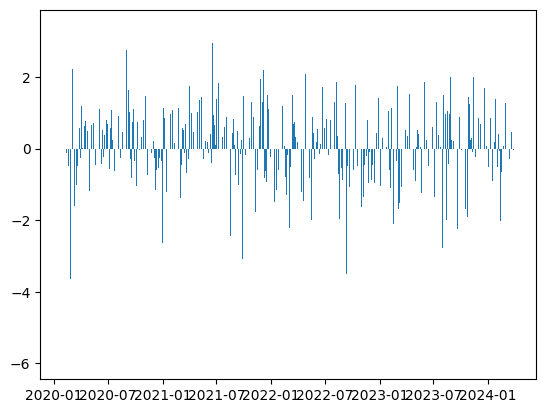

In [ ]:
plt.bar(dates, spikes)

## Option Back Test

In [ ]:
import os
import sys
import numpy as np

In [ ]:
data_folder_path = os.path.join(os.getcwd(), 'option_data')
sys.path.append(data_folder_path)

In [ ]:
from option_data import OptionFactory
import utils

In [ ]:
start_date: str = "2024-02-05"
end_date: str = '2024-03-22'
ticker: str = "META"
expiration: str = '2024-03-22'
K: int = 460

In [ ]:
def historical_option_price(ticker: str, K: int, start_date: str, end_date: str, expiration: str, option_style: str = "european", option_type: str = "call") -> list[float]:

    close_dates: list[str] = utils.option_date_range(start_date, end_date)

    meta_option_price_list: list[int] = []

    for close_date in close_dates:
        option_price: float = OptionFactory().create_option(ticker, K, expiration, close_date, option_style, option_type).get_price()
        meta_option_price_list.append(option_price)

    return meta_option_price_list, close_dates

In [ ]:
import matplotlib.pyplot as plt

def plot_option_price(x: list[str], y: list[float]):

    plt.figure()
    plt.plot(x, y)
    plt.xticks(rotation=60)
    plt.xlabel("Close Date")
    plt.ylabel("Option Price")
    plt.show()

In [ ]:
ticker = "SPY"
start_date = "2024-02-15"
end_date = "2024-04-15"
expiration = "2024-04-19"
K1 = 500
K2 = 510

spy_call_k1, dates1 = historical_option_price(ticker, K1, start_date, end_date, expiration)
spy_call_k2, dates2 = historical_option_price(ticker, K2, start_date, end_date, expiration)

In [ ]:
call_spread = np.array(spy_call_k1) - np.array(spy_call_k2)

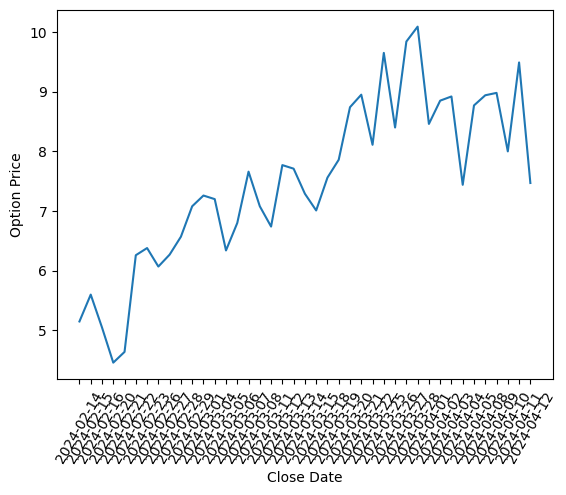

In [ ]:
plot_option_price(dates1, call_spread)

## Refactores Data Processor
##### Take data+processor.py out of data module and make seperate data_processor.py

## Arbitrage checker

In [16]:
from data.option_data.process_option_chain import OptionFactory
#from data.option_data.option_graph_arbitrage_checker import ButterflyArbitrage

In [17]:
close_date = "2025-01-02"
ticker = "SPY"
S = 584
T = 30/252

In [18]:
call_graph = OptionFactory().create_option_graph(ticker, close_date)
put_graph = OptionFactory().create_option_graph(ticker, close_date)

In [ ]:

class ButterflyArbitrage:

    def __init__(self, call_graph, put_graph) -> None:
        self.call_graph = call_graph
        self.put_graph = put_graph

    def check_calls(self):
        exps = list(self.call_graph.get_expirations())
        for exp in exps:
            skew = self.call_graph.get_skew(exp)
            call_strikes = skew.strikes()
            call_prices = skew.prices()
            for i in range(1, len(call_strikes) - 1):
                butterfly_price = call_prices[i - 1] - 2 * call_prices[i] + call_prices[i + 1]

In [23]:
butterfly_arb = ButterflyArbitrage(call_graph, put_graph)
butterfly_arb.check_calls()

410.0
173.41
420.0
169.01
430.0
160.01
440.0
143.48
450.0
133.49
460.0
123.58
470.0
113.64
480.0
103.73
499.0
84.9
500.0
89.0
505.0
79.0
525.0
59.46
530.0
59.34
535.0
49.79
540.0
46.96
545.0
42.27
550.0
31.92
555.0
38.41
560.0
27.96
565.0
18.7
570.0
14.9
571.0
10.0
575.0
9.16
577.0
7.49
579.0
5.11
580.0
4.91
581.0
3.41
582.0
2.99
583.0
2.04
584.0
1.01
585.0
0.27
586.0
0.03
587.0
0.01
588.0
0.01
589.0
0.01
590.0
0.01
591.0
0.01
592.0
0.01
593.0
0.01
594.0
0.01
595.0
0.01
596.0
0.01
597.0
0.01
598.0
0.01
599.0
0.01
600.0
0.01
601.0
0.01
602.0
0.01
603.0
0.01
604.0
0.01
605.0
0.01
606.0
0.01
607.0
0.01
608.0
0.01
609.0
0.01
610.0
0.01
611.0
0.01
612.0
0.01
613.0
0.01
614.0
0.01
615.0
0.01
620.0
0.01
625.0
0.01
630.0
0.01
635.0
0.01
640.0
0.01
645.0
0.01
650.0
0.01
655.0
0.01
660.0
0.01
665.0
0.01
310.0
275.74
330.0
262.91
360.0
234.7
420.0
173.62
430.0
172.34
440.0
160.19
450.0
138.21
460.0
126.17
465.0
139.5
470.0
134.5
475.0
129.4
480.0
114.15
485.0
97.81
495.0
87.96
500.0
85.01
505.0
8

# Junsu Park Vol Lec 5 Realized Vol and Log Return Plot
#### We want to recreate the below
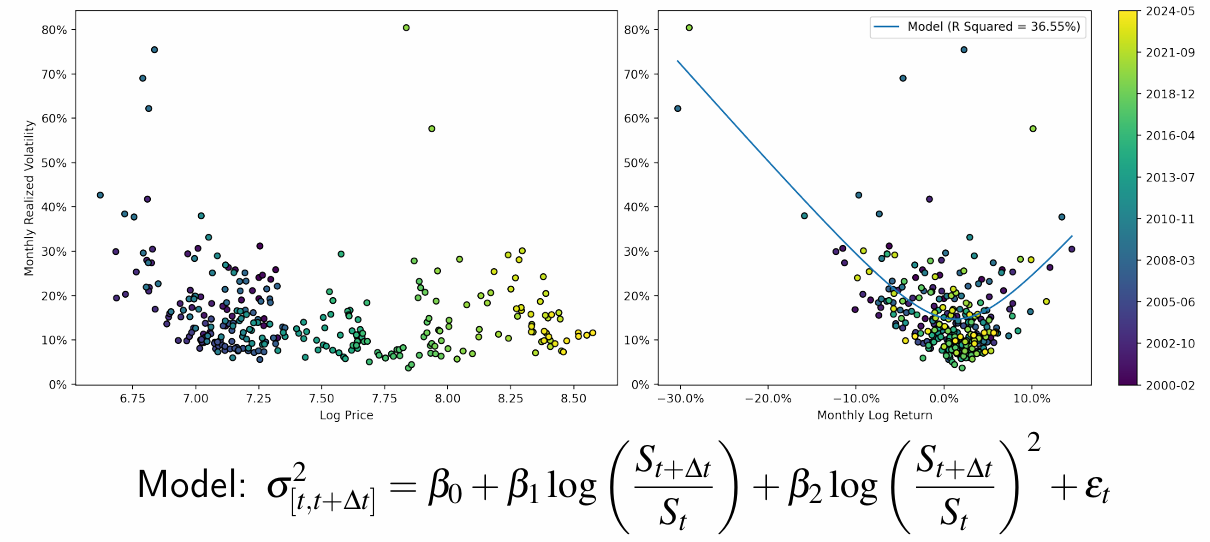

In [10]:
from data.price_data import process_price_data
from calc_engine.volatility.realized_volatility import historical_price_volatility

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [30]:
close_to_close_vol = historical_price_volatility.CloseToClose()

log_rets = process_price_data.get_log_rets("SPY", "2015-01-01", "2025-01-01")
rvol = close_to_close_vol.calculate("SPY", "2015-01-01", "2025-01-01")

2494
2494


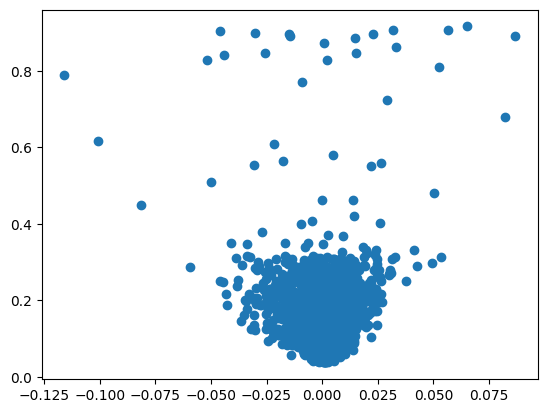

In [31]:
print(len(log_rets[21:]))
print(len(rvol))
plt.scatter(log_rets[21:], rvol)

#### Create regression

In [32]:
X = pd.DataFrame({
    'log_return:': log_rets[21:],
    'log_return_squared': log_rets[21:] ** 2
})

X = sm.add_constant(X)
y = rvol

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     372.1
Date:                Fri, 16 May 2025   Prob (F-statistic):          4.10e-142
Time:                        13:38:10   Log-Likelihood:                 2603.8
No. Observations:                2494   AIC:                            -5202.
Df Residuals:                    2491   BIC:                            -5184.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1352      0

C:\Users\dibia\AppData\Local\Temp\ipykernel_18048\2549413028.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  skew = coeff[0] + coeff[1] * log_ret_sorted + coeff[2] * log_ret_sorted ** 2


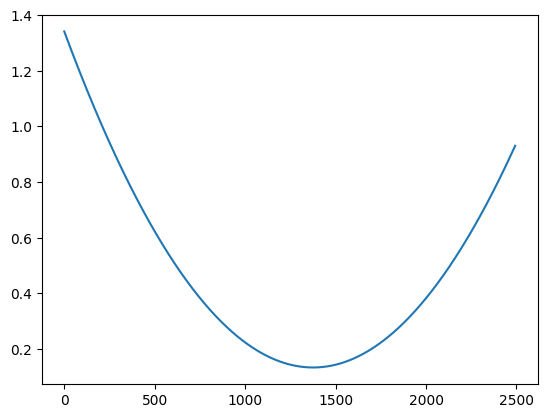

In [36]:
coeff = model.params
log_ret_sorted = np.linspace(log_rets[21:].min(), log_rets[21:].max(), len(rvol))
skew = coeff[0] + coeff[1] * log_ret_sorted + coeff[2] * log_ret_sorted ** 2
plt.plot(skew)

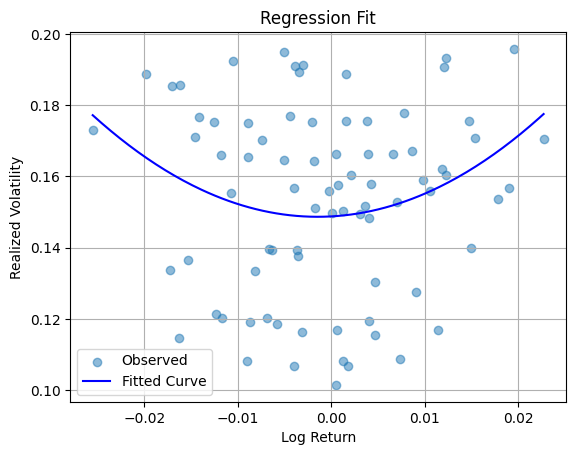

In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assume you have prices
# log_returns = np.log(prices / prices.shift(1))

# Simulated example
np.random.seed(0)
log_rets = pd.Series(np.random.normal(0, 0.01, 100))
realized_vol = log_rets.rolling(21).std() * np.sqrt(252)

# Align data: drop NaN from realized_vol, which will also drop the first 20 log_rets
data = pd.DataFrame({
    'log_ret': log_rets,
    'log_ret_sq': log_rets ** 2,
    'realized_vol': realized_vol
}).dropna()

# Set up regression
X = sm.add_constant(data[['log_ret', 'log_ret_sq']])
y = data['realized_vol']
model = sm.OLS(y, X).fit()
coeff = model.params

# Fitted values
data['fitted'] = model.predict(X)

# Plot
plt.scatter(data['log_ret'], data['realized_vol'], alpha=0.5, label='Observed')
# Plot curve
x_vals = np.linspace(data['log_ret'].min(), data['log_ret'].max(), 200)
fitted_curve = coeff['const'] + coeff['log_ret'] * x_vals + coeff['log_ret_sq'] * x_vals**2
plt.plot(x_vals, fitted_curve, color='blue', label='Fitted Curve')

plt.xlabel('Log Return')
plt.ylabel('Realized Volatility')
plt.title('Regression Fit')
plt.legend()
plt.grid(True)
plt.show()


#### The first plot is my version, the second is chat GPT's later I will incorporate this into my project
#### I believe the first coefficient is vol level, the second is skewness and the third is kurtosis

# Realized Spot Vol Covariance 6/6/2025

In [1]:
from data.data_processor.data_processor import MarketPriceProcessor, VolatilityProcessor
from data.price_data.process_price_data import get_log_rets
from calc_engine.volatility import iv_calc, gvv

In [ ]:
ticker = "SPY"
start = "2025-01-01"
end = "2025-05-10"
log_rets, dates = get_log_rets(ticker, start, end)

for date in dates:
    mark_proc = MarketPriceProcessor(ticker, date)
    strikes, prices = mark_proc.put_call_price_skew()

In [5]:
log_rets

array([ 1.24258113e-02,  5.74410547e-03, -1.13683976e-02,  1.45985147e-03,
       -1.53852087e-02,  1.54927955e-03,  1.37507849e-03,  1.80265647e-02,
       -1.92501994e-03,  9.98981578e-03,  9.11187525e-03,  5.60566509e-03,
        5.44330319e-03, -2.92359370e-03, -1.42463535e-02,  8.55569798e-03,
       -4.49302703e-03,  5.35272970e-03, -5.33614876e-03, -6.75231357e-03,
        6.68588643e-03,  4.04633239e-03,  3.46960968e-03, -9.19568488e-03,
        6.76820246e-03,  7.60327630e-04, -3.22669203e-03,  1.05021960e-02,
       -4.91987136e-05,  2.93152861e-03,  2.35211523e-03, -4.16893321e-03,
       -1.72520681e-02, -4.56082217e-03, -4.98557951e-03,  5.04671934e-04,
       -1.60907018e-02,  1.54850649e-02, -1.76752438e-02, -1.19074784e-02,
        1.06904797e-02, -1.79105300e-02,  5.58918524e-03, -2.69967167e-02,
       -8.34762278e-03,  5.29250645e-03, -1.34201501e-02,  2.04453170e-02,
        7.68180163e-03, -1.08672958e-02,  1.08319984e-02, -2.89592370e-03,
        3.29807435e-04,  